# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [145]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [146]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

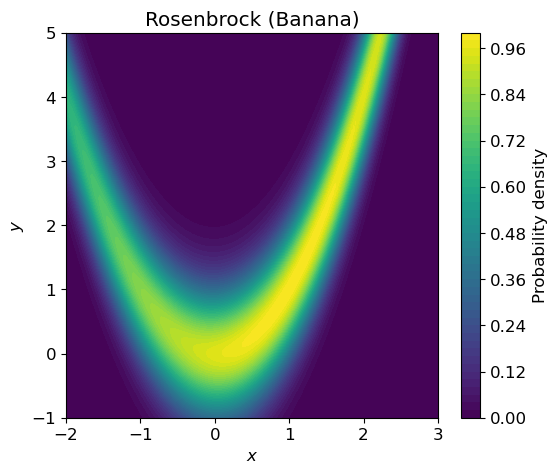

In [147]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [148]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [149]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [150]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 74.78%


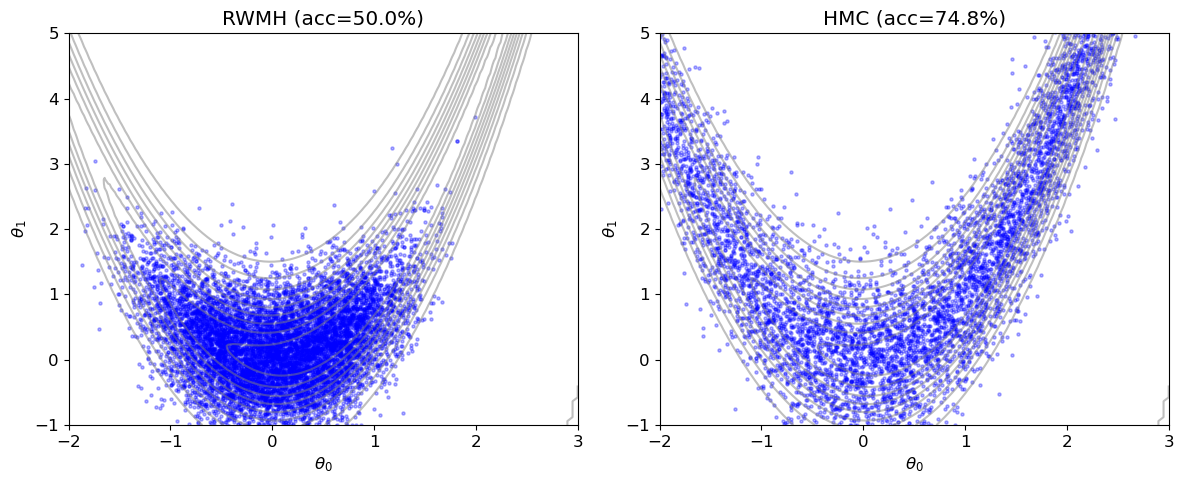

In [151]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [152]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))

In [153]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324


RWMH Trace Plots:


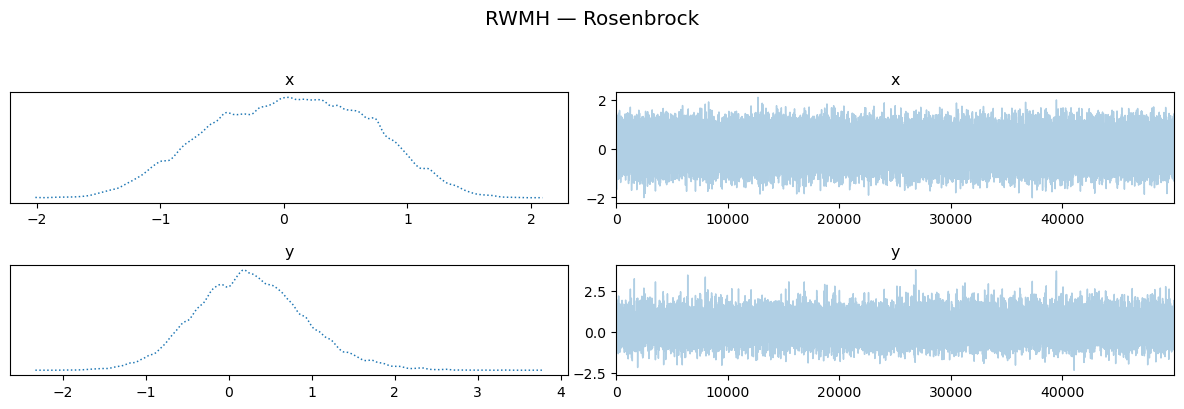


HMC Trace Plots:


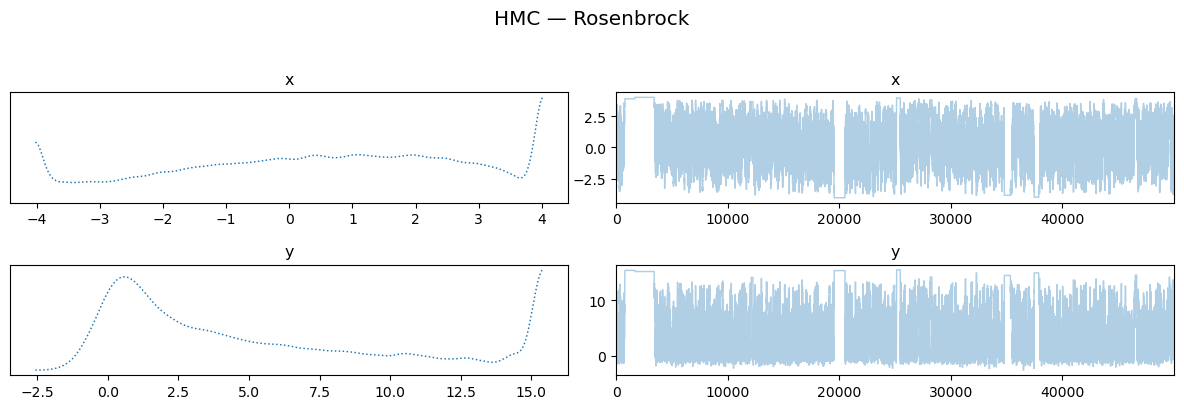

In [154]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

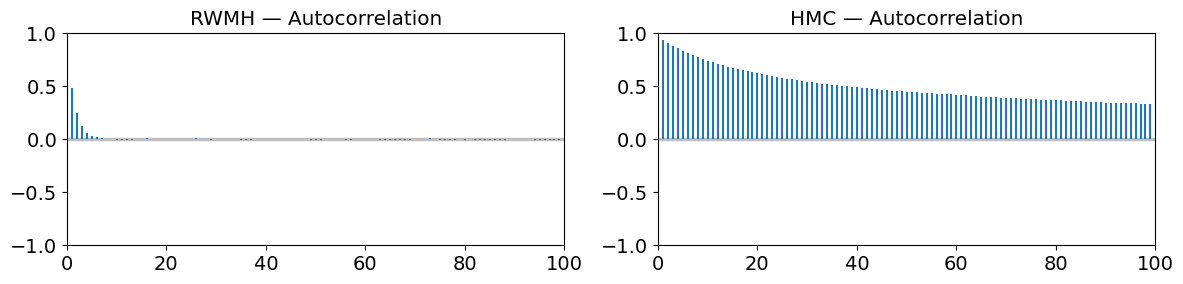

In [155]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

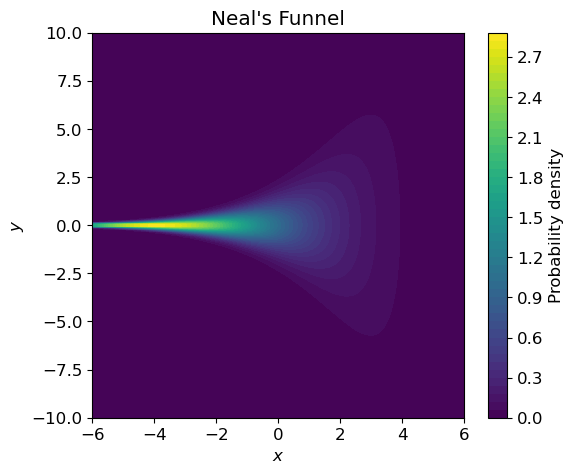

In [156]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

Tuning RWMH on Neal's Funnel:
  sigma=0.05: acceptance=98.57%
  sigma= 0.1: acceptance=96.98%
  sigma= 0.2: acceptance=94.38%
  sigma= 0.3: acceptance=91.52%
  sigma= 0.5: acceptance=85.18%
  sigma= 1.0: acceptance=65.56%
  sigma= 1.3: acceptance=55.12%
  sigma= 1.5: acceptance=48.68%

Chosen RWMH sigma=1.3, acceptance=55.12%
RWMH final acceptance rate: 55.17%

Tuning HMC on Neal's Funnel:
  step_size=0.01, L=10: acceptance=100.00%
  step_size=0.01, L=20: acceptance=99.91%
  step_size=0.01, L=30: acceptance=99.94%
  step_size=0.02, L=10: acceptance=99.61%
  step_size=0.02, L=20: acceptance=99.74%
  step_size=0.02, L=30: acceptance=99.92%
  step_size=0.03, L=10: acceptance=99.51%
  step_size=0.03, L=20: acceptance=99.60%
  step_size=0.03, L=30: acceptance=99.46%
  step_size=0.05, L=10: acceptance=99.49%
  step_size=0.05, L=20: acceptance=99.36%
  step_size=0.05, L=30: acceptance=99.03%
  step_size=0.08, L=10: acceptance=97.97%
  step_size=0.08, L=20: acceptance=98.02%
  step_size=0.08, 

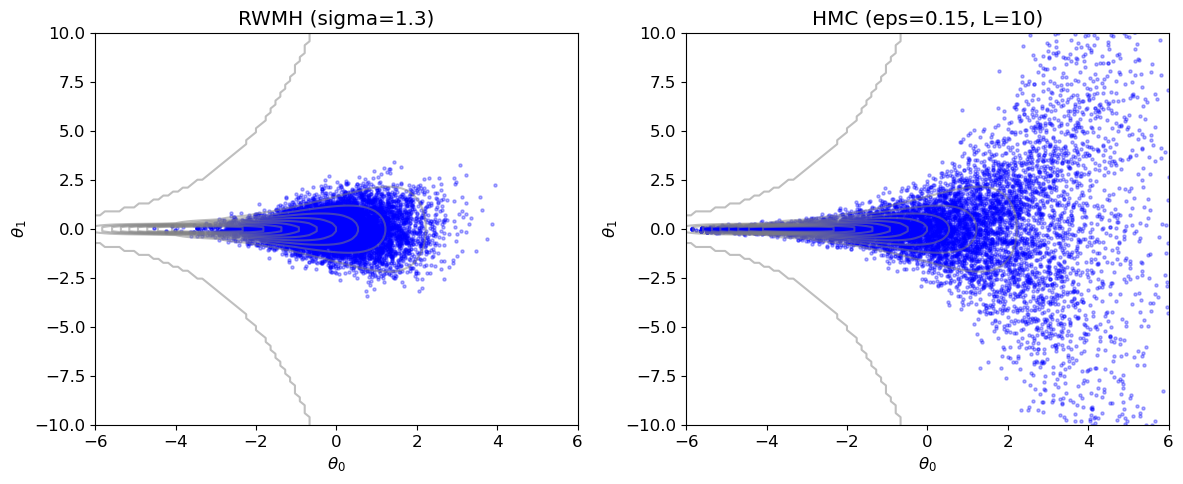


=== RWMH — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.236,1.126,-2.385,1.850
x,-0.004,0.777,-1.494,1.541



=== HMC — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,0.197,2.799,-5.255,5.093
x,0.438,5.243,-8.599,9.307


RWMH Trace Plots:


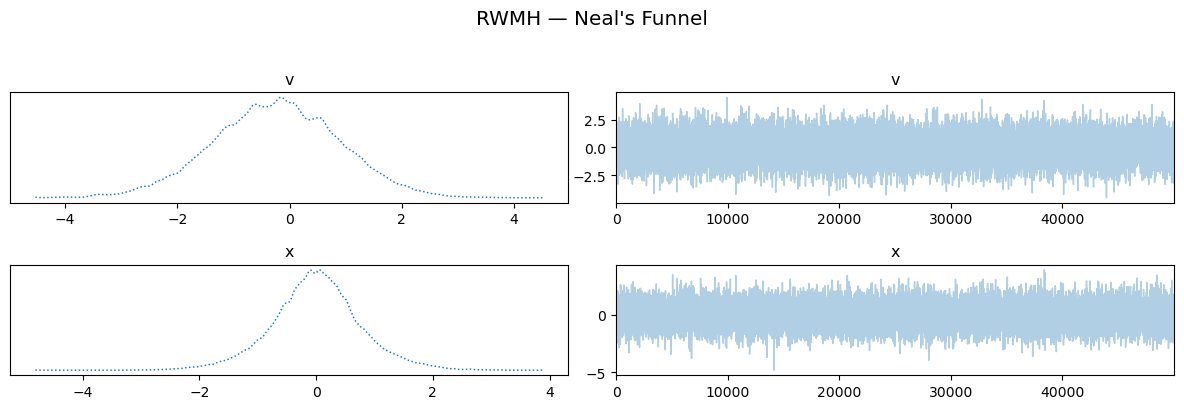


HMC Trace Plots:


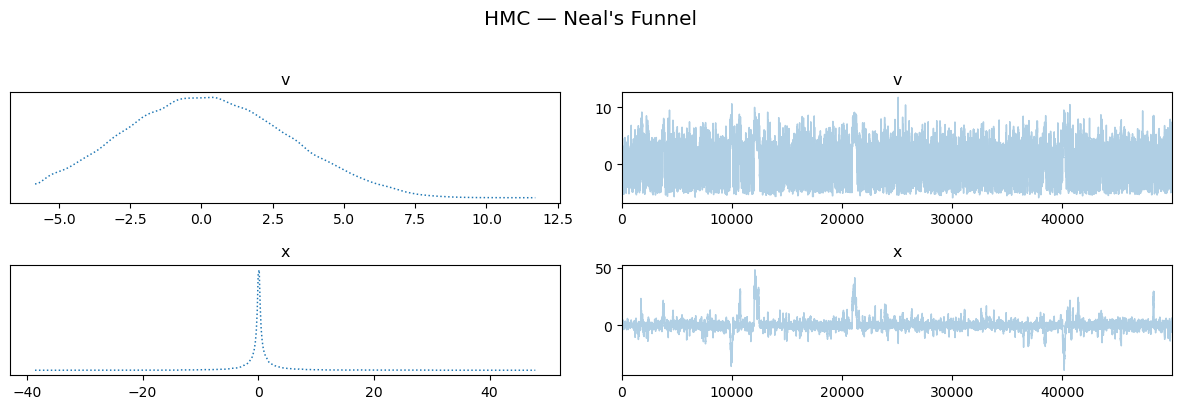

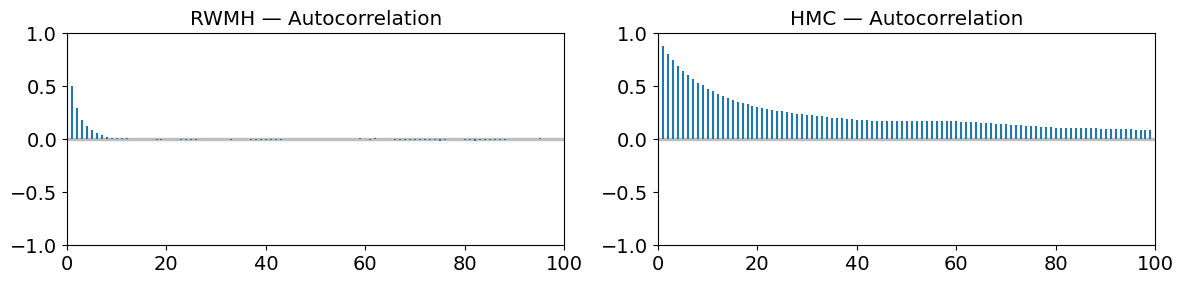

In [157]:
# TODO: Run the RWMH and HMC baselines on Neal's Funnel
# Use the same workflow as Rosenbrock above — you'll need to tune hyperparameters!
# --- Neal's Funnel baselines: RWMH + HMC (with simple tuning) ---

key = jr.PRNGKey(123)
key_r, key_h = jr.split(key, 2)

initial_pos = jnp.array([0.0, 0.0])   # theta = [v, x]
n_samples = 50_000


# 1) Tune RWMH sigma

sigmas = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 1.3, 1.5]
best_rwmh = None

print("Tuning RWMH on Neal's Funnel:")
for s in sigmas:
    k_try, key_r = jr.split(key_r)
    samples, acc = run_rwmh(k_try, log_prob_funnel, initial_pos, sigma=s, n_samples=20_000)
    print(f"  sigma={s:>4}: acceptance={acc:.2%}")
    if best_rwmh is None and (0.20 <= acc <= 0.60):
        best_rwmh = (s, samples, acc)

if best_rwmh is None:
    s = sigmas[-1]
    rwmh_sigma = s
    rwmh_samples, rwmh_acc = samples, acc
else:
    rwmh_sigma, rwmh_samples, rwmh_acc = best_rwmh

print(f"\nChosen RWMH sigma={rwmh_sigma}, acceptance={rwmh_acc:.2%}")

k_full, key_r = jr.split(key_r)
rwmh_samples, rwmh_acc = run_rwmh(k_full, log_prob_funnel, initial_pos, sigma=rwmh_sigma, n_samples=n_samples)
print(f"RWMH final acceptance rate: {rwmh_acc:.2%}")



# 2) Tune HMC step_size (and optionally n_leapfrog)

step_sizes = [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.15, 0.18, 0.2, 0.22, 0.25, 0.28]
leapfrogs = [10, 20, 30]  

best_hmc = None
print("\nTuning HMC on Neal's Funnel:")
for eps in step_sizes:
    for L in leapfrogs:
        k_try, key_h = jr.split(key_h)
        samples, acc = run_hmc(k_try, log_prob_funnel, initial_pos, step_size=eps, n_leapfrog=L, n_samples=20_000)
        print(f"  step_size={eps:>4}, L={L:>2}: acceptance={acc:.2%}")
        if best_hmc is None and (0.65 <= acc <= 0.90):
            best_hmc = (eps, L, samples, acc)

if best_hmc is None:
    hmc_step_size, hmc_L = 0.03, 20
else:
    hmc_step_size, hmc_L, _, _ = best_hmc

print(f"\nChosen HMC step_size={hmc_step_size}, n_leapfrog={hmc_L}")

k_full, key_h = jr.split(key_h)
hmc_samples, hmc_acc = run_hmc(k_full, log_prob_funnel, initial_pos, step_size=hmc_step_size, n_leapfrog=hmc_L, n_samples=n_samples)
print(f"HMC final acceptance rate: {hmc_acc:.2%}")



# 3) Visual comparison plot (same helper as above)

plot_samples_comparison(
    rwmh_samples, hmc_samples,
    f"RWMH (sigma={rwmh_sigma})",
    f"HMC (eps={hmc_step_size}, L={hmc_L})",
    log_prob_funnel,
    xlim=(-6, 6),     
    ylim=(-10, 10),   
)

# 4) Diagnostics (ArviZ)
var_names = ["v", "x"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata  = samples_to_inference_data(hmc_samples, var_names)

summarize_sampler(rwmh_samples, "RWMH — Neal's Funnel", var_names)
summarize_sampler(hmc_samples,  "HMC — Neal's Funnel", var_names)

print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()


---
## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

- **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
- **Hybrid methods**: Combine different move types (e.g., local + global moves)
- **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
- **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!

In [158]:
# TODO: Test your sampler on both benchmarks (Rosenbrock and Neal's Funnel)
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)
import jax
import jax.numpy as jnp
import jax.random as jr


def _gaussian_logpdf(x, mean, sigma):
    """Log N(x | mean, sigma^2 I) up to the normalizing constant."""
    z = (x - mean) / sigma
    return -0.5 * jnp.sum(z * z)


def run_my_sampler(
    key,
    log_prob_fn,
    initial_position,
    n_samples=150_000,
    step_size=0.8,
    adapt_steps=5_000,
    target_accept=0.4,
    Temperature = 0.8
):
    

    grad_logp = jax.grad(log_prob_fn)

    log_eps0 = jnp.log(step_size)

    def one_step(carry, key_t):
        theta, log_eps, t = carry

        eps = jnp.exp(log_eps)

        g = grad_logp(theta)
        mean_fwd = theta + 0.5 * (eps ** 2) * g
        #Noise added
        noise = jr.normal(key_t, shape=theta.shape)
        theta_prop = mean_fwd + eps * noise

        
        logp_theta = log_prob_fn(theta) / Temperature
        logp_prop  = log_prob_fn(theta_prop)/ Temperature

        g_prop = grad_logp(theta_prop)
        mean_bwd = theta_prop + 0.5 * (eps ** 2) * g_prop

        log_q_fwd = _gaussian_logpdf(theta_prop, mean_fwd, eps)
        log_q_bwd = _gaussian_logpdf(theta,      mean_bwd, eps)

        log_alpha = (logp_prop - logp_theta) + (log_q_bwd - log_q_fwd)

        u = jnp.log(jr.uniform(jr.fold_in(key_t, 9999)))
        accept = u < jnp.minimum(0.0, log_alpha)

        theta_new = jnp.where(accept, theta_prop, theta)

        # --- Adapt step size during warmup ---
        # Robbins–Monro update on log_eps (diminishing learning rate)
        # If accept > target -> increase eps; else decrease.
        eta = 1.0 / jnp.power(t + 10.0, 0.6)  # stable diminishing schedule
        do_adapt = t < adapt_steps
        log_eps_new = jnp.where(
            do_adapt,
            log_eps + eta * ((accept.astype(jnp.float32)) - target_accept),
            log_eps
        )

        carry_new = (theta_new, log_eps_new, t + 1)
        out = (theta_new, accept, eps)
        return carry_new, out

    keys = jr.split(key, n_samples)
    init_carry = (initial_position, log_eps0, jnp.array(0.0))

    (_, log_eps_T, _), (thetas, accepts, eps_hist) = jax.lax.scan(one_step, init_carry, keys)


    final_eps = jnp.exp(log_eps_T)

    acc_rate = jnp.mean(accepts.astype(jnp.float32))
    return thetas, acc_rate, final_eps, accepts, eps_hist




In [159]:
key = jr.PRNGKey(42)
initial_pos = jnp.array([0.0, 0.0])

rmh_samples, rmh_acc = run_rwmh(
    key,
    log_prob_rosenbrock,
    initial_pos,
    sigma=0.3,      
    n_samples=50_000
)

print("RWMH acceptance:", float(rmh_acc))


key = jr.PRNGKey(0)
initial_pos = jnp.array([0.0, 0.0])

my_samples_ros, my_acc_ros, my_eps_ros, _, _ = run_my_sampler(
    key,
    log_prob_rosenbrock,
    initial_pos,
    n_samples=150_000,
    step_size=0.8,
    adapt_steps=5_000,
    target_accept=0.4,
    Temperature = 0.8
)

print("Rosenbrock: MALA acceptance =", float(my_acc_ros))
print("Rosenbrock: final step_size =", float(my_eps_ros))

RWMH acceptance: 0.9319799542427063
Rosenbrock: MALA acceptance = 0.14189332723617554
Rosenbrock: final step_size = 0.8079867959022522


In [160]:
# TODO: Compare to baselines
# - Visualize samples (scatter plot with contours)
# - Compute ESS using samples_to_inference_data() and az.summary()
# - Plot traces and autocorrelation
# - Discuss: where does your method work well? Where does it struggle?

#  It works well on the Neal’s Funnel distribution, and is good at exploring the narrow tail, but it doesn’t work on another distribution. 



In [161]:
import matplotlib.pyplot as plt
import arviz as az

def diagnostics(samples, var_names, title, max_lag=200):
    """ESS + trace + autocorr for a (draws, dim) sample array."""
    idata = samples_to_inference_data(samples, var_names=var_names)

    print(f"\n=== {title} ===")
    summ = az.summary(idata)
    print(summ)

    # Trace
    az.plot_trace(idata, combined=True, figsize=(12, 4))
    plt.suptitle(f"{title} — Trace", y=1.02)
    plt.tight_layout()
    plt.show()

    # Autocorralation
    fig, axes = plt.subplots(1, len(var_names), figsize=(5 * len(var_names), 3))
    if len(var_names) == 1:
        axes = [axes]
    for ax, name in zip(axes, var_names):
        az.plot_autocorr(idata, var_names=[name], ax=ax, combined=True, max_lag=max_lag)
        ax.set_title(f"{title} — Autocorr: {name}")
    plt.tight_layout()
    plt.show()

    return summ, idata


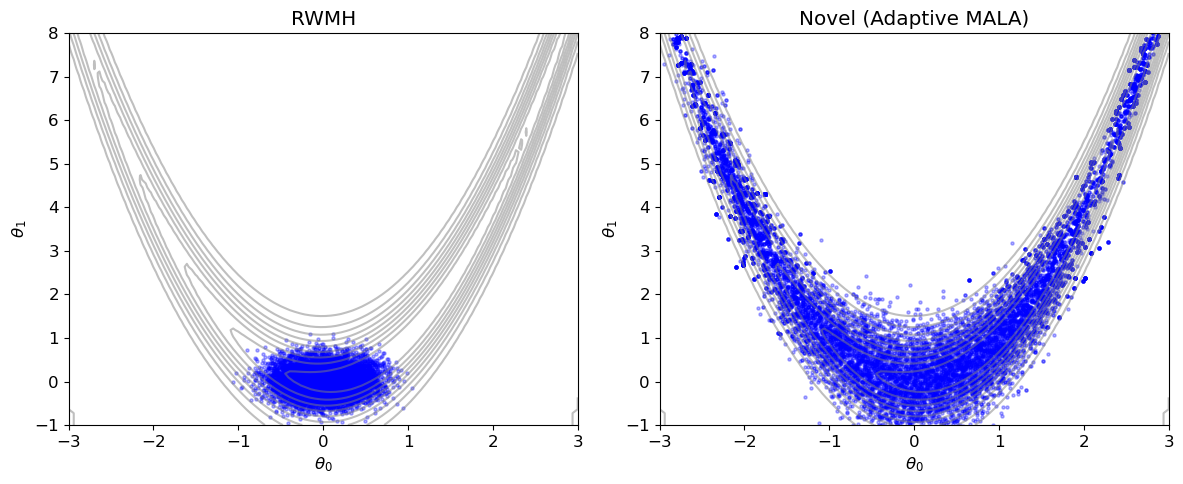

<Figure size 1000x400 with 0 Axes>

arviz - WARNING - Shape validation failed: input_shape: (1, 150000), minimum_shape: (chains=2, draws=4)



=== Rosenbrock — Novel (Adaptive MALA) ===
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -1.926  2.451  -5.213    2.540      1.890    0.170       2.0      24.0   
y  9.707  8.262  -0.574   25.977      6.357    1.342       2.0      31.0   

   r_hat  
x    NaN  
y    NaN  


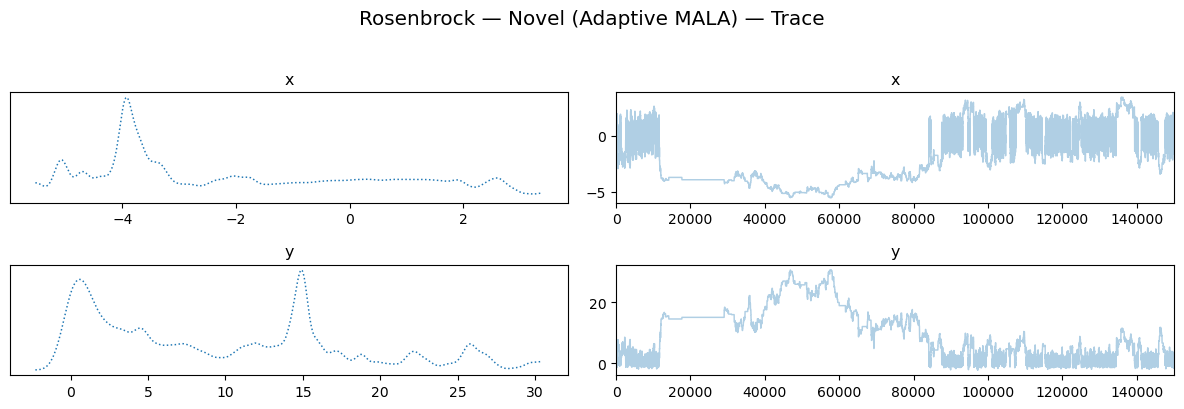

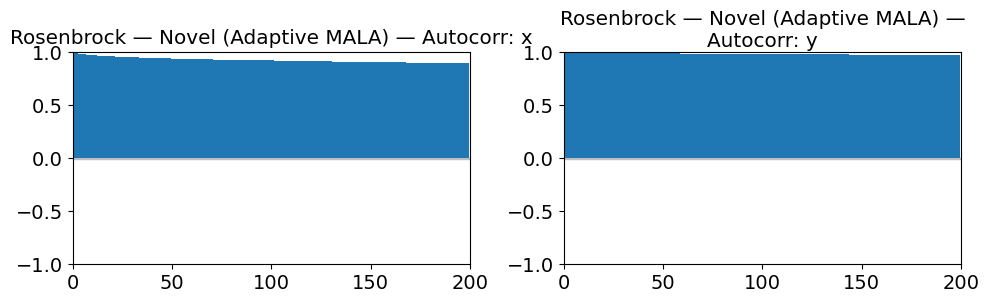

<Figure size 1000x400 with 0 Axes>

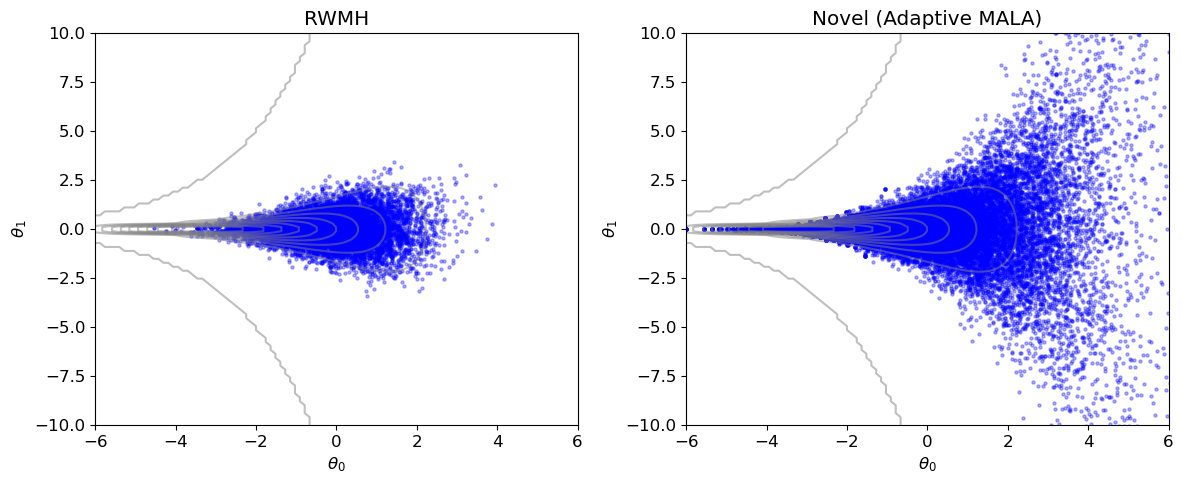

<Figure size 1000x400 with 0 Axes>

arviz - WARNING - Shape validation failed: input_shape: (1, 150000), minimum_shape: (chains=2, draws=4)



=== Neal's Funnel — Novel (Adaptive MALA) ===
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v -0.502  2.271  -4.349    3.803      0.065    0.038    1108.0     671.0   
x  0.003  2.432  -3.762    3.888      0.073    0.251    3583.0    2731.0   

   r_hat  
v    NaN  
x    NaN  


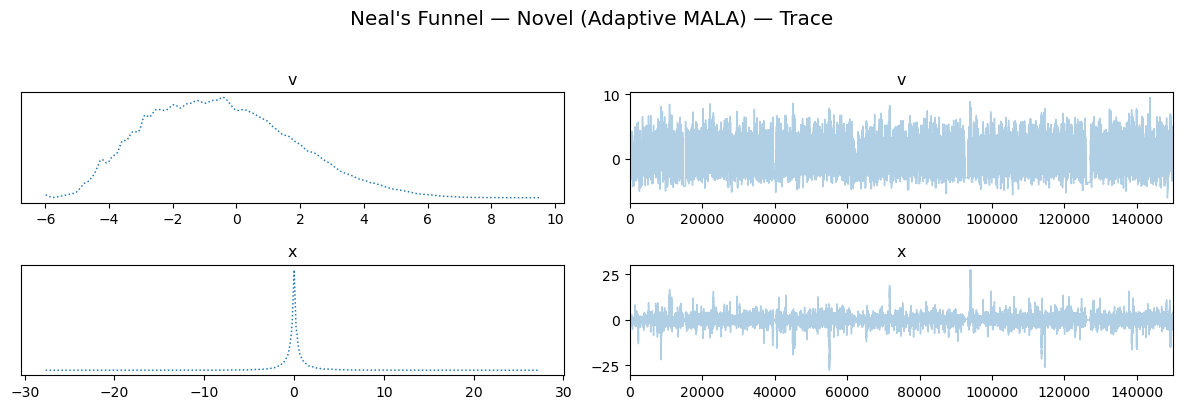

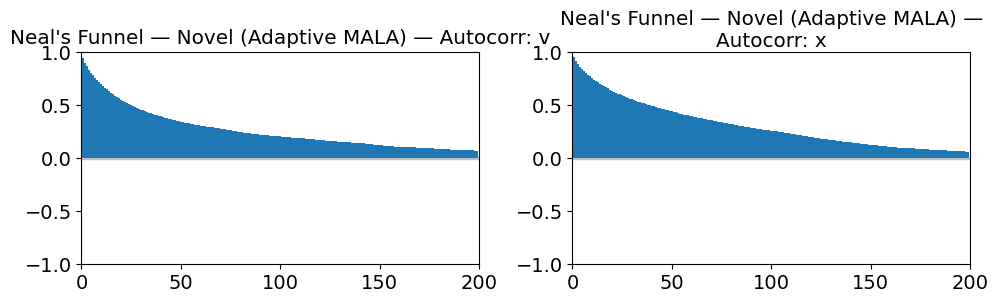

<Figure size 1000x400 with 0 Axes>

In [ ]:

plot_samples_comparison(
    rmh_samples, my_samples_ros,
    "RWMH", "Novel (Adaptive MALA)",
    log_prob_rosenbrock,
    xlim=(-3, 3),
    ylim=(-1, 8),
)
plt.savefig("rosenbrock_scatter.png", dpi=200, bbox_inches="tight")
plt.show()


diagnostics(my_samples_ros,  ["x", "y"], "Rosenbrock — Novel (Adaptive MALA)")
plt.savefig("rosenbrock_trace_autocorr.png", dpi=200, bbox_inches="tight")
plt.show()
plot_samples_comparison(
    rwmh_samples, my_samples_fun,
    "RWMH", "Novel (Adaptive MALA)",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)
plt.savefig("funnel_scatter.png", dpi=200, bbox_inches="tight")
plt.show()

diagnostics(my_samples_fun,  ["v", "x"], "Neal's Funnel — Novel (Adaptive MALA)")
plt.savefig("funnel_trace_autocorr.png", dpi=200, bbox_inches="tight")
plt.show()
#  It works well on the Neal’s Funnel distribution, and is good at exploring the narrow tail, but it doesn’t work on another distribution. 


In [ ]:
# TODO: Ablation study
# - What are the key hyperparameters of your method?
# Sample sizes, temperature, adaptive steps, step size, and acceptance. 

# - How sensitive is performance to each one?
#They are sensitive to every hyperparameter, more detailed explanation in the report.
# - What happens in limiting cases (e.g., turning off a component)?
#Turning off temperature and adaptive steps have influences on the model, they are less variant when they are stuck in one place. 

